Importing the relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy.stats import shapiro

Importing the data

In [2]:
data=pd.read_excel('WorldBank_India_GDP_1960-2022.xlsx')
t=data['Year']
Y=data['GDP_Ind_Dollars']

Plotting GDP against Years

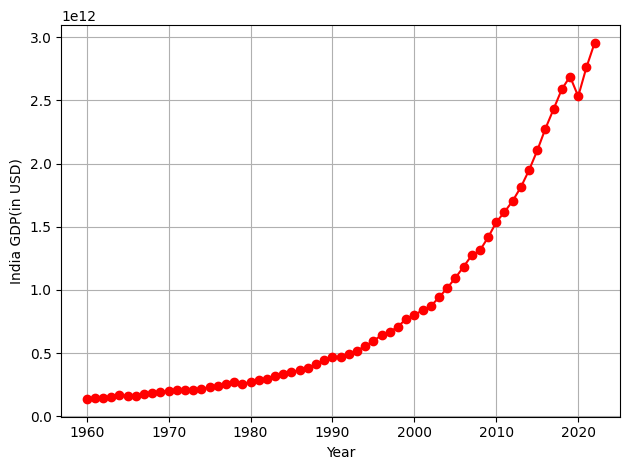

In [3]:
plt.figure()
plt.plot(t,Y,"r-o")
plt.xlabel("Year")
plt.ylabel("India GDP(in USD)")
plt.tight_layout()
plt.grid(visible=True)
plt.show('GDP_vs_Year.png')

As it is a time series, ARIMA(p,d,q) would suit well. We need to determine the value of p,d and q. Starting with d

In [4]:
print("P-value at d= 0:",adfuller(Y)[1]) 
print("P-value at d= 1:",adfuller(Y.diff().dropna())[1])
print("P-value at d= 2:",adfuller(Y.diff().diff().dropna())[1])

P-value at d= 0: 1.0
P-value at d= 1: 1.0
P-value at d= 2: 0.451213635397457


From above P values, we determine d=2.
Using ACF and PACF to determine p and q for d=2.

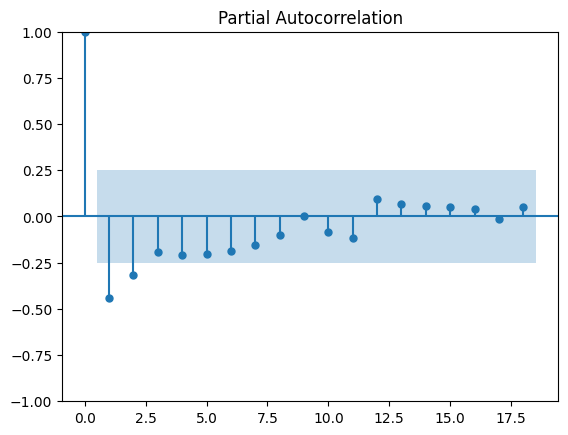

In [21]:
d2Y=Y.diff().diff().dropna()
plot_pacf(d2Y)
plt.show()

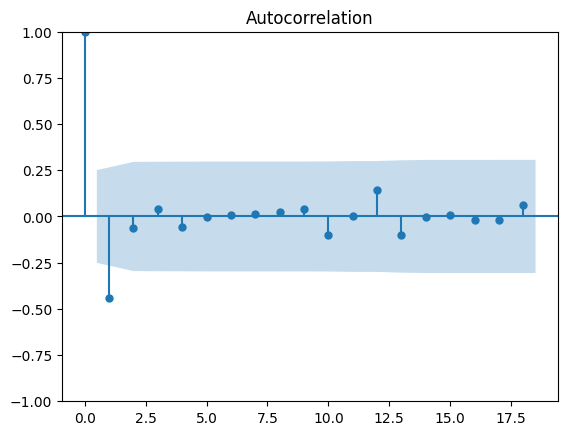

In [20]:
plot_acf(d2Y)
plt.show()

From the graphs, it is clear that p=0 and q=1

Confirming our findings with the auto_arima method

In [3]:
stepwise_fit=auto_arima(Y[0:58],start_p=0,start_q=0,
                        max_p=2,max_q=1,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(stepwise_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1402.042
Date:                Sat, 11 Nov 2023   AIC                           2808.084
Time:                        14:46:16   BIC                           2812.135
Sample:                             0   HQIC                          2809.655
                                 - 58                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2969      0.083     -3.591      0.000      -0.459      -0.135
sigma2      3.315e+20   3.18e-23   1.04e+43      0.000    3.31e+20    3.31e+20
Ljung-Box (L1) (Q):                   0.62   Jarque-

ARIMA(0,2,1) is to be used. Training the model

In [61]:
train_data=data[0:58] #Training on 1960-2017
test_data=data[58:]  #Testing on 2018-2022

model=ARIMA(train_data['GDP_Ind_Dollars'],order=(0,2,1))
arima_model=model.fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:        GDP_Ind_Dollars   No. Observations:                   58
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1402.042
Date:                Fri, 10 Nov 2023   AIC                           2808.084
Time:                        18:00:31   BIC                           2812.135
Sample:                             0   HQIC                          2809.655
                                 - 58                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2969      0.083     -3.591      0.000      -0.459      -0.135
sigma2      3.315e+20   3.18e-23   1.04e+43      0.000    3.31e+20    3.31e+20
Ljung-Box (L1) (Q):                   0.62   Jarque-

Diagnostic Checking

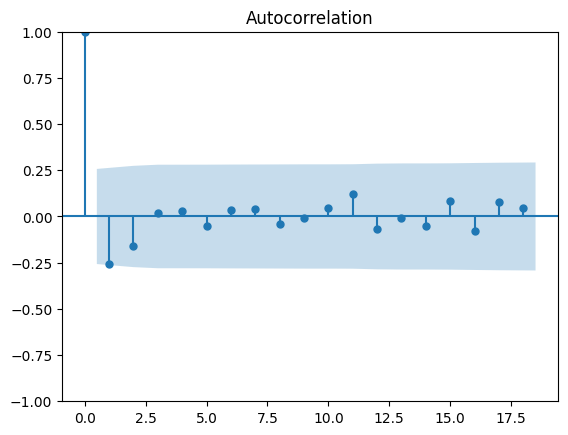

In [103]:
plot_acf(arima_model.resid)
plt.show()

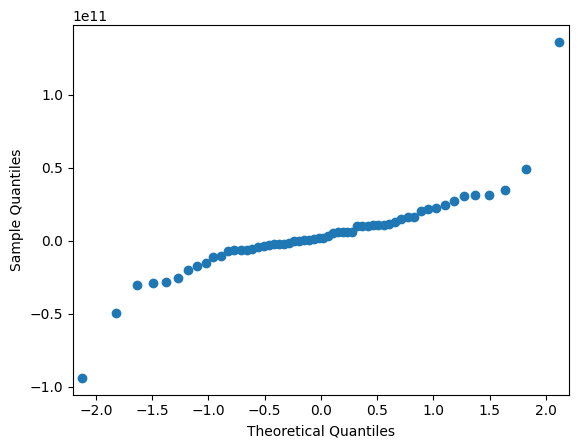

In [116]:
ax=sm.qqplot(arima_model.resid)
# sm.qqline(ax,arima_model.resid)
plt.show()

In [118]:
shapiro(arima_model.resid)

ShapiroResult(statistic=0.8213626146316528, pvalue=6.764381055290869e-07)

Visualizing the predictions on the entire dataset

In [62]:
predictions=arima_model.predict(0,62).rename('Predictions')

In [63]:
print(predictions.tail())
print(Y.tail())

58    2.590001e+12
59    2.747986e+12
60    2.905970e+12
61    3.063955e+12
62    3.221940e+12
Name: Predictions, dtype: float64
58    2.588975e+12
59    2.689205e+12
60    2.532396e+12
61    2.761585e+12
62    2.954978e+12
Name: GDP_Ind_Dollars, dtype: float64


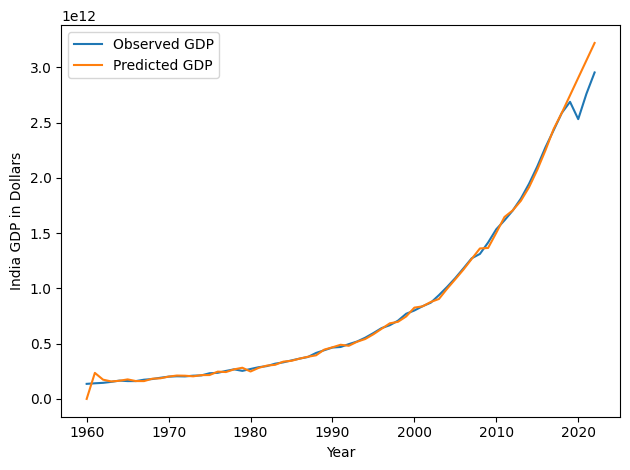

In [64]:
plt.plot(t,Y,label='Observed GDP')
plt.plot(t,predictions,label='Predicted GDP')
plt.xlabel('Year')
plt.ylabel('India GDP in Dollars')
plt.legend()
plt.tight_layout()
plt.show()

Error Analysis

In [65]:
rmse_train=rmse(Y[:58],predictions[:58])
rmse_test=rmse(Y[58:],predictions[58:])
rmse_entire=rmse(Y,predictions)
print("RMSE VALUES:::")
print("Training set(1960-2017): %.2e" %rmse_train)
print("Test set(2018-2022): %.2e" %rmse_test)
print("Entire set(1960-2022): %.2e" %rmse_entire)

corr_train=np.corrcoef(Y[:58],predictions[:58])
corr_test=np.corrcoef(Y[58:],predictions[58:])
corr_entire=np.corrcoef(Y,predictions)
print("CORR. COEFF.S:::")
print("Training set(1960-2017): %.4f" %corr_train[0,1])
print("Test set(2018-2022): %.4f" %corr_test[0,1])
print("Entire set(1960-2022): %.4f" %corr_entire[0,1])

RMSE VALUES:::
Training set(1960-2017): 2.81e+10
Test set(2018-2022): 2.47e+11
Entire set(1960-2022): 7.47e+10
CORR. COEFF.S:::
Training set(1960-2017): 0.9990
Test set(2018-2022): 0.7698
Entire set(1960-2022): 0.9970


Forecasting for the future(2023-2030)

In [90]:
future=arima_model.predict(63,70).rename("Future")


In [91]:
df_curr=pd.DataFrame()
df_curr["Years"]=t
df_curr["Predictions"]=predictions
df_fut=pd.DataFrame()
df_fut["Years"]=pd.Series([x for x in range(2023,2031)]).set_axis([x for x in range(63,71)])
df_fut["Predictions"]=future
print(df_fut)

    Years   Predictions
63   2023  3.379925e+12
64   2024  3.537909e+12
65   2025  3.695894e+12
66   2026  3.853879e+12
67   2027  4.011864e+12
68   2028  4.169848e+12
69   2029  4.327833e+12
70   2030  4.485818e+12


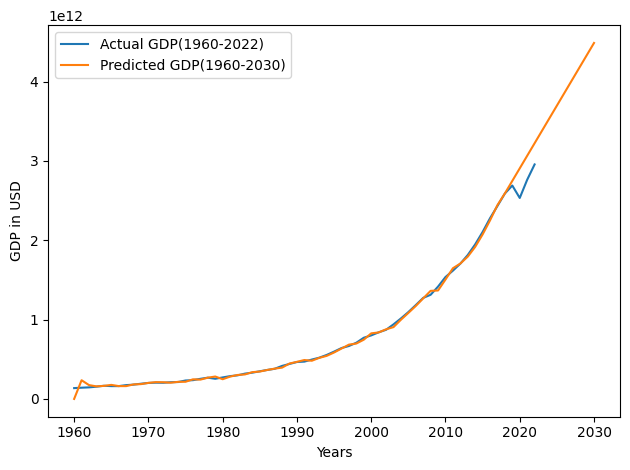

In [96]:
df=pd.concat([df_curr,df_fut])
plt.plot(t,Y,label="Actual GDP(1960-2022)")
plt.plot(df.Years,df.Predictions,label="Predicted GDP(1960-2030)")
plt.xlabel("Years")
plt.ylabel("GDP in USD")
plt.tight_layout()
plt.legend()
plt.show()

Extra: Using entire dataset for prediction

In [119]:
model2=ARIMA(Y,order=(0,2,1))
arima_model2=model2.fit()

In [120]:
predictions2=arima_model2.predict(0,62).rename('Predictions')
future2=arima_model2.predict(63,70).rename("Future")

In [122]:
df_curr2=pd.DataFrame()
df_curr2["Years"]=t
df_curr2["Predictions"]=predictions2
df_fut2=pd.DataFrame()
df_fut2["Years"]=pd.Series([x for x in range(2023,2031)]).set_axis([x for x in range(63,71)])
df_fut2["Predictions"]=future2

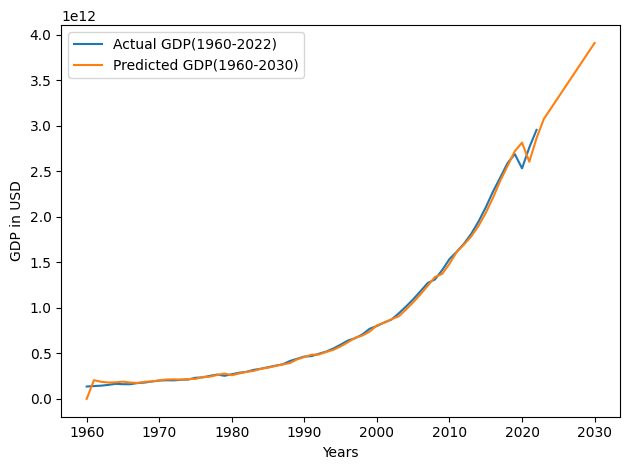

In [123]:
df2=pd.concat([df_curr2,df_fut2])
plt.plot(t,Y,label="Actual GDP(1960-2022)")
plt.plot(df2.Years,df2.Predictions,label="Predicted GDP(1960-2030)")
plt.xlabel("Years")
plt.ylabel("GDP in USD")
plt.tight_layout()
plt.legend()
plt.show()

In [125]:
rmse_entire2=rmse(Y,predictions2)
corr_entire2=np.corrcoef(Y,predictions2)
print("RMSE: %.2e" %rmse_entire2)
print("CORR: %.4f" %corr_entire2[0,1])

RMSE: 5.18e+10
CORR: 0.9980
